In [13]:
import numpy as np
import readgadget
import matplotlib.pyplot as plt
import pandas as pd

# FUNCTIONS 

## 2D Axis ratio

In [2]:
from structural_properties.fits2ds import Inertia3D, Inertia2D, get_new_axpos2D, get_axes2D


def plot_part_axes2D(newpart, iaxes=None, haloc=[0,0], rvir=1):
    ''' Handy way to plot the distribution of particles and axes''' 
    fig, ax = plt.subplots(1,1, figsize=(4, 4))

    ax.scatter(newpart[:, 0], newpart[:, 1], s=1)
    ax.scatter(haloc[0], haloc[1], s=10)
    c1 = plt.Circle((haloc[0], haloc[1]), rvir, color='k', fill=False)
    ax.add_patch(c1)
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlabel('X [Mpc/h]')
    if type(iaxes)==np.ndarray:
        for j in range(2):
            xs = [-iaxes[j][0], iaxes[j][0]]
            ys = [-iaxes[j][1], iaxes[j][1]]
            ax.plot(xs, ys, color='C{}'.format(2*j+1), label='Axis {}'.format(j))
        ax.legend()

## $\chi^2$ of the Mass profile 

In [2]:
from structural_properties.fits2ds import hubble_ratio, rhos, rhotilde, Ntilde, prob3D, sigma_tilde, N_tilde2D, NFW3d, Mass_NFW, Mass_NFW2d, NFW2d, chi_square

G = 4.30091e-9   #Units Mpc/Msun x (km/s)^2
rho_c = 3*100**2/(8*np.pi*G)       # h^2xMsun/Mpc**3



## Concentration minimisation 

In [4]:
from structural_properties.fits2ds import prob2D, N_frac, likelihood, minimisation

## Most bound particle 

In [5]:
from structural_properties.fits2ds import g_pot_r, get_binding_e

# Simulation info 

In [6]:
sim = 'm3s85'
snp = 118
folder = '/home/ayuba/scratch/{}/'.format(sim)

In [7]:
print(folder)

/home/ayuba/scratch/m3s85/


In [8]:
snap = 'snapdir_{:03}/snapshot_{:03}'.format(snp, snp)
head     = readgadget.header(folder+snap)
BoxSize  = head.boxsize  #Mpc/h
Nall     = head.nall         #Total number of particles 
Masses   = head.massarr*1e10 #Masses of the particles in Msun/h 
mpart = Masses[1]
#compute mean density from snapshot                                 
mean_background = Nall[1]/BoxSize**3
print(mean_background)

8.589934592


## Halo Positions 

In [9]:
with open(folder+sim+'_prefixes.txt', 'r') as file:
    prefixes = file.read().splitlines()
pdhalos = pd.read_table(folder+'AHF/halos/{}.AHF_halos'.format(prefixes[118-snp]), delim_whitespace=True, header=0)

In [10]:
pdhalos.keys()

Index(['#ID(1)', 'hostHalo(2)', 'numSubStruct(3)', 'Mhalo(4)', 'npart(5)',
       'Xc(6)', 'Yc(7)', 'Zc(8)', 'VXc(9)', 'VYc(10)', 'VZc(11)', 'Rhalo(12)',
       'Rmax(13)', 'r2(14)', 'mbp_offset(15)', 'com_offset(16)', 'Vmax(17)',
       'v_esc(18)', 'sigV(19)', 'lambda(20)', 'lambdaE(21)', 'Lx(22)',
       'Ly(23)', 'Lz(24)', 'b(25)', 'c(26)', 'Eax(27)', 'Eay(28)', 'Eaz(29)',
       'Ebx(30)', 'Eby(31)', 'Ebz(32)', 'Ecx(33)', 'Ecy(34)', 'Ecz(35)',
       'ovdens(36)', 'nbins(37)', 'fMhires(38)', 'Ekin(39)', 'Epot(40)',
       'SurfP(41)', 'Phi0(42)', 'cNFW(43)'],
      dtype='object')

In [11]:
halo_inf = np.load(folder+'parts_near_hals_{}_snap{}.npy'.format(sim, snp), allow_pickle=True)


## All in one 

In [12]:
from structural_properties.fits2ds import load_parts, get_axe, get_mbp_off1, get_com_off1, get_conc3d, get_conc2d, get_chi3d, get_chi2d

## Ok, test each one 

Text(0.5, 1.0, '0.29')

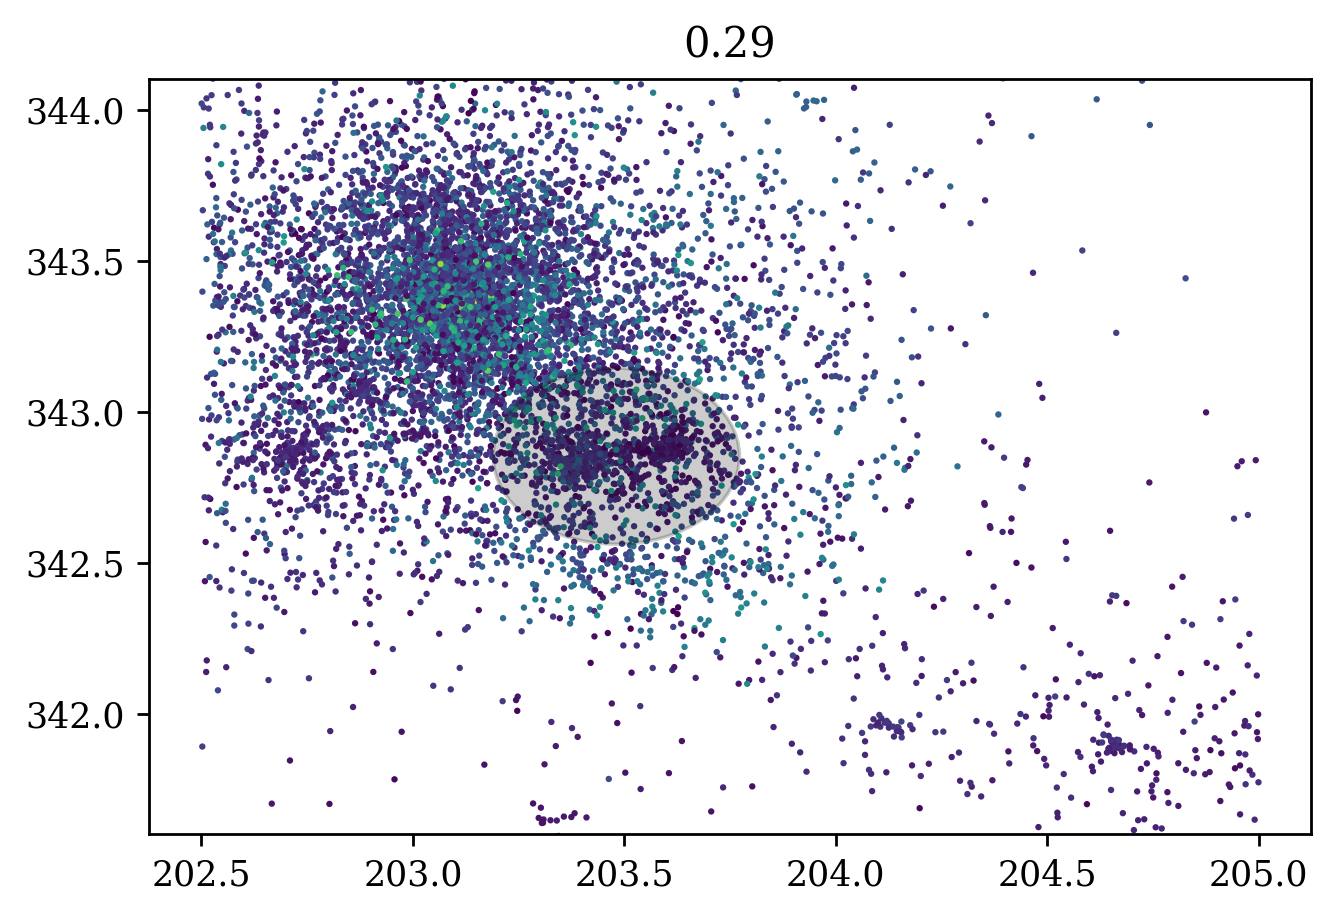

In [144]:
halo_id = 50
vels, part_pos, halo_c, vel_h, rvir, mvir, rads3d, rads2 = load_parts(halo_inf, pdhalos, halo_id)
plt.scatter(part_pos[:,0], part_pos[:,2], s=0.7, c=np.sum(vels**2, axis=1))
#plt.scatter(part_pos[:,0], part_pos[:,2], s=2, c=bE, cmap='seismic')

c1 = plt.Circle((halo_c[0], halo_c[2]), rvir, alpha=0.2, color='k')
ax = plt.gca()
fig = plt.gcf()
fig.figsize=[10,10]
ax.add_patch(c1)
plt.ylim(halo_c[2]-1.25, halo_c[2]+1.25)
#plt.xlim(213.5, 214.45)

plt.title('{:1.2f}'.format(rvir))

In [145]:
pec_vel = vels-vel_h
pr, bE = get_binding_e(part_pos, pec_vel, halo_c, nbins=1000)


### Axes ratio 

(-2.0, 2.0)

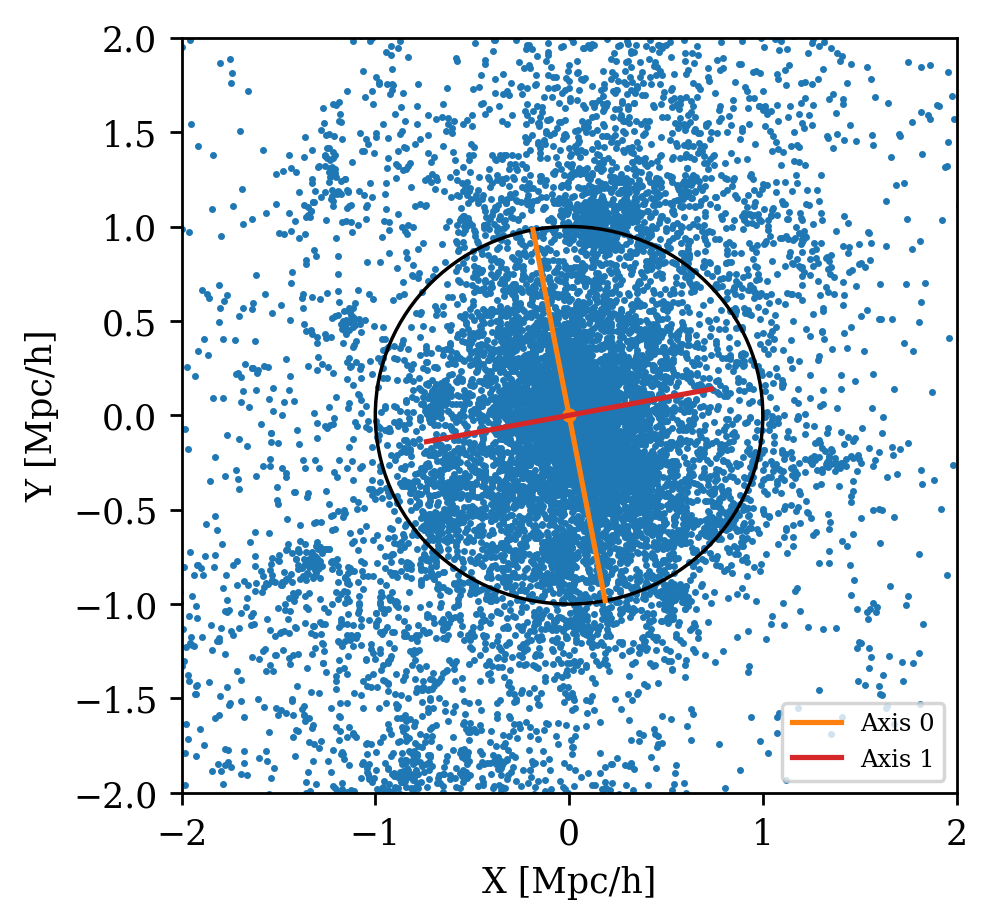

In [49]:
axes, vecs = get_axe(part_pos, halo_c)

iaxes = np.array([vecs[0][:,0], axes[0]*vecs[0][:,1]])
plot_part_axes2D((part_pos[:,:-1]-halo_c[:-1])/rvir, iaxes)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

### mbp offset 

In [62]:
off, pot = get_mbp_off1(part_pos, vels, halo_c, vel_h)

In [40]:
ahf_off = np.array(pdhalos['mbp_offset(15)']/1e3)

In [106]:
off = []
for halo_id in range(len(halo_inf)):
    #halo_id = 3000
    vels, part_pos, halo_c, vel_h, rvir, mvir, rads3d, rads2 = load_parts(halo_inf, pdhalos, halo_id)
    npos, nvels = part_pos[rads3d<rvir,:], vels[rads3d<rvir,:]
    off.append(get_mbp_off1(npos, nvels, halo_c, vel_h)[0])


In [113]:
margs = np.where(off[:,0]>0.1)[0]

In [111]:
off = np.array(off)

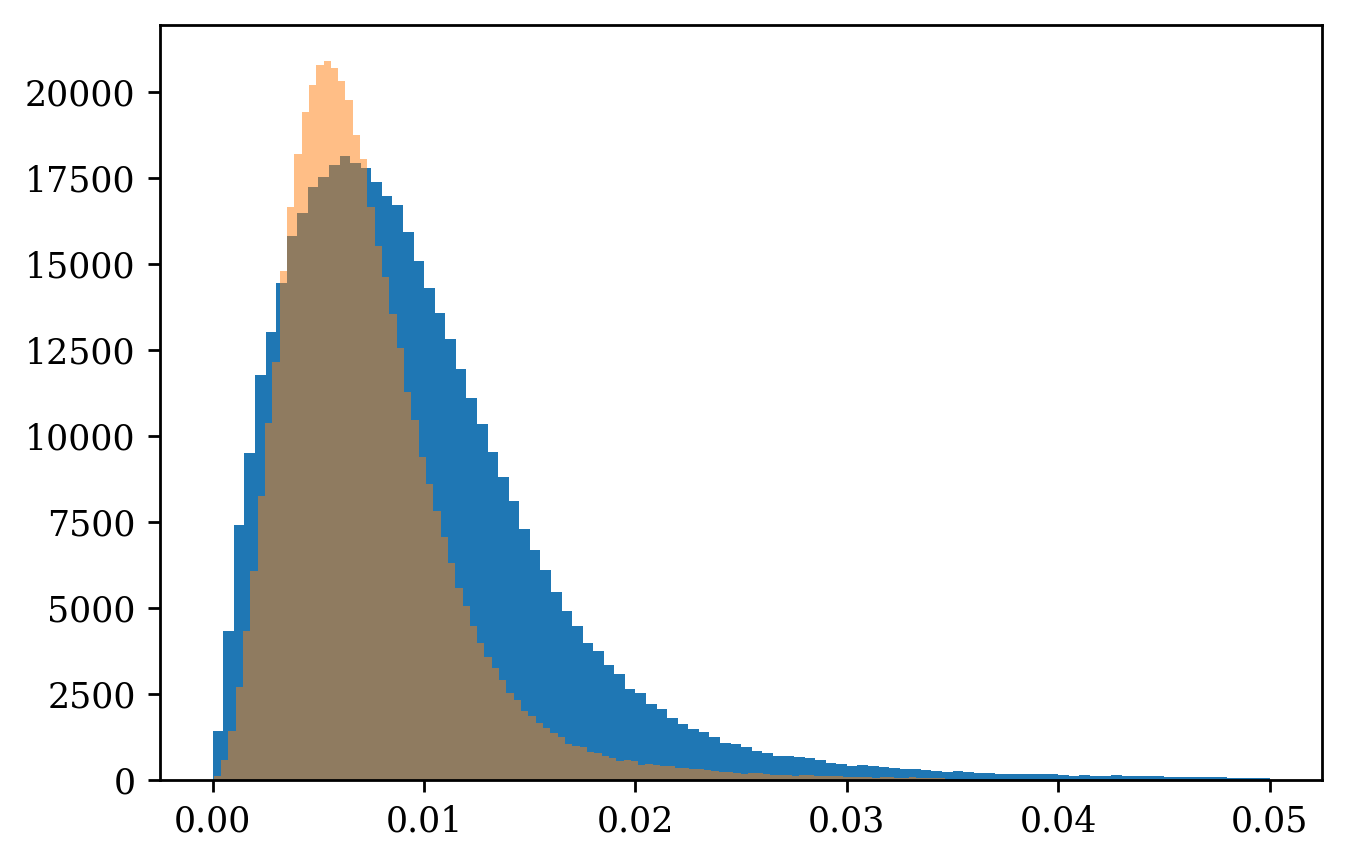

In [150]:
h1 = plt.hist(off[off[:,0]<0.05,0], bins=100)
h2 = plt.hist(ahf_off, alpha=0.5, bins=100)

### COM off 

In [24]:
off3d, off2d = [], []
for halo_id in range(len(halo_inf)):
    #halo_id = 3000
    vels, part_pos, halo_c, vel_h, rvir, mvir, rads3d, rads2 = load_parts(halo_inf, pdhalos, halo_id)
    #npos, nvels = part_pos[rads3d<rvir,:], vels[rads3d<rvir,:]
    res3d, res2d = get_com_off1(part_pos, rads3d, rvir, halo_c)
    off3d.append(res3d)
    off2d.append(res2d)
off3d = np.array(off3d)
off2d = np.array(off2d)

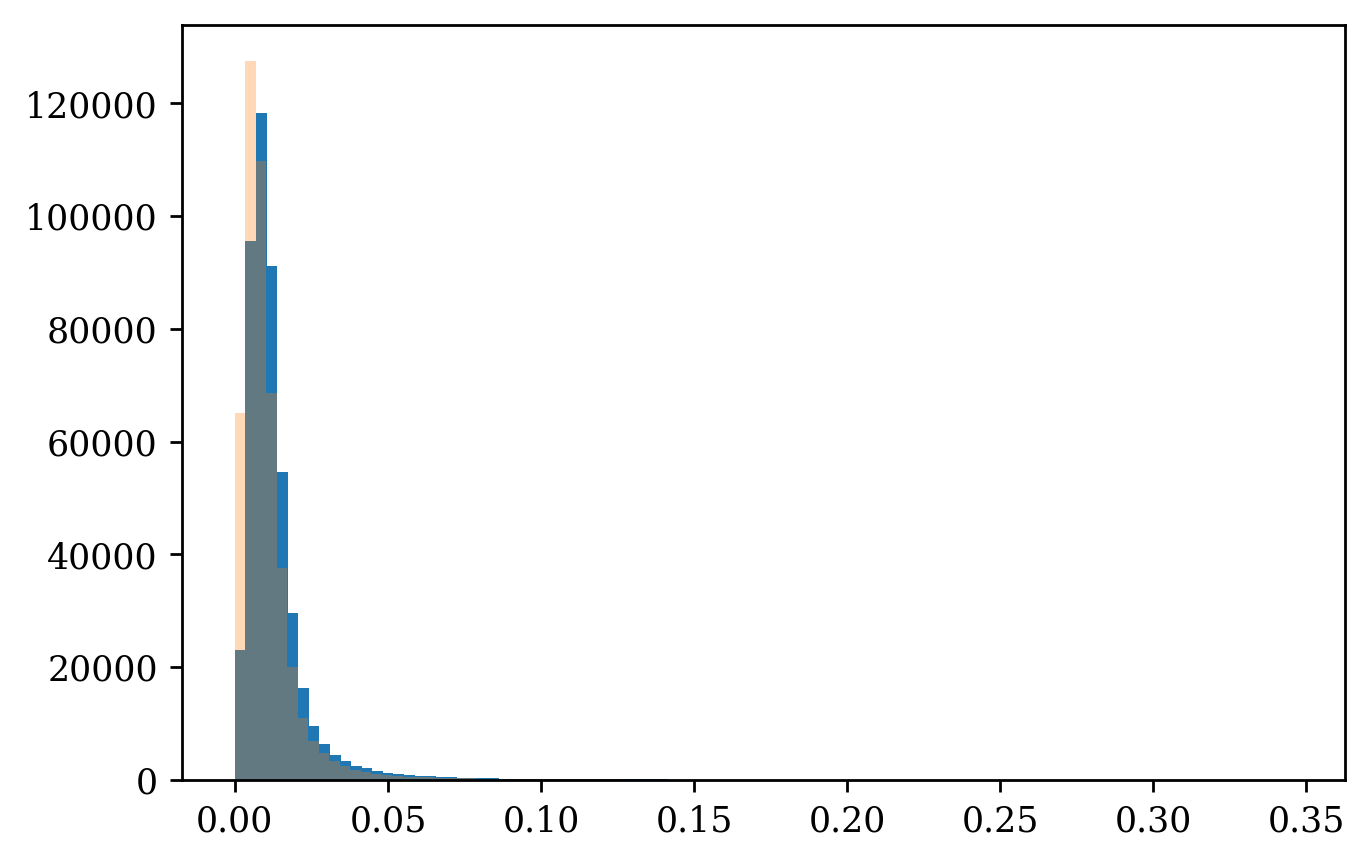

In [30]:
h1 = plt.hist(pdhalos['com_offset(16)']/1e3, bins = 100)
#h2 = plt.hist(off2d[off3d<0.1, 0], alpha=0.3, bins=100)
h3 = plt.hist(off2d[:,1], alpha=0.3, bins=100)


### CONC2D

In [ ]:
conc2d = []
conc3d = []
for halo_id in range(len(halo_inf)):
    vels, part_pos, halo_c, vel_h, rvir, mvir, rads3d, rads2d = load_parts(halo_inf, pdhalos, halo_id)
    conc3d.append(get_conc3d(rads3d, rvir, rmin=0, rmax=1.2))
    #conc2d.append(get_conc2d(rads2d, rvir, rmin=0, rmax=1.2))

/tmp/ipykernel_24933/2358577096.py:21: RuntimeWarning: invalid value encountered in log
  likelihood = np.sum(-np.log(func(rad_arrays[indices], rmin, rmax, loga)))
/tmp/ipykernel_24933/2358577096.py:21: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(-np.log(func(rad_arrays[indices], rmin, rmax, loga)))
/tmp/ipykernel_24933/2358577096.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return a1*a2/a3b


### $\chi^2$ 

In [72]:
chi2d = []
conc2d = np.load(folder+'concxy_{}_snap{}.npy'.format(sim, snp))
#conc3d = []
for halo_id in range(len(halo_inf)):
    vels, part_pos, halo_c, vel_h, rvir, mvir, rads3d, rads2d = load_parts(halo_inf, pdhalos, halo_id)
    chi2d.append(get_chi2d(conc2d[halo_id], rads2d[0], rvir, mvir, z=0))
    #conc2d.append(get_conc2d(rads2d, rvir, rmin=0, rmax=1.2))

/tmp/ipykernel_20398/3350033799.py:118: RuntimeWarning: invalid value encountered in log10
  return np.sum((np.log10(f(x_data)/y_data))**2)/nbins
/tmp/ipykernel_20398/3350033799.py:118: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((np.log10(f(x_data)/y_data))**2)/nbins


In [77]:
chi2d = np.array(chi2d)

In [81]:
np.save(folder+'chisquare_xy_{}_snap{}.npy'.format(sim, snp), chi2d)


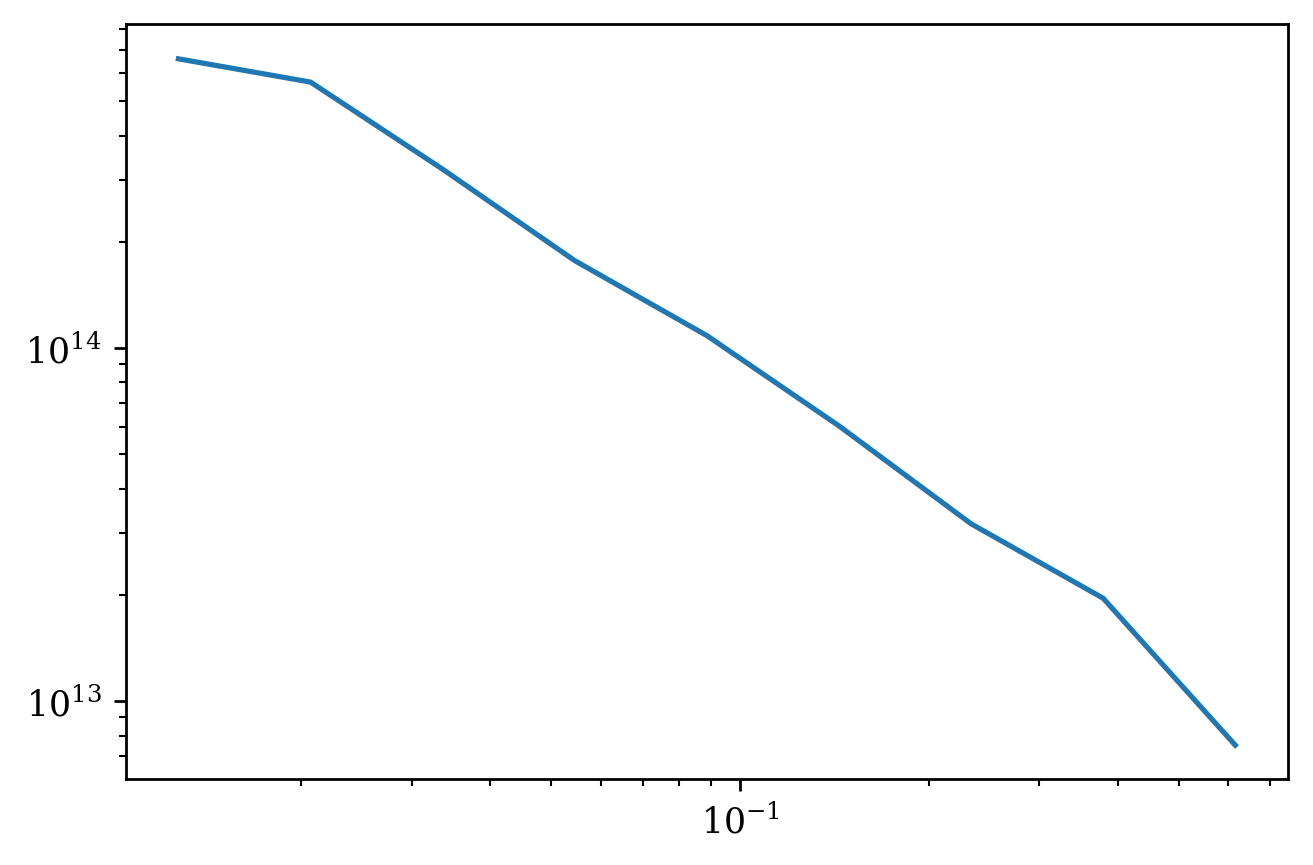

In [70]:
vels, part_pos, halo_c, vel_h, rvir, mvir, rads3d, rads2d = load_parts(halo_inf, pdhalos, halo_id)
rads = rads2d[0]
redbins = np.logspace(-2, np.log10(2*rvir), 10)
binsurf = 2*np.pi*np.sqrt(redbins[1:]*redbins[:-1])*(redbins[1:] - redbins[:-1]) #Mpc**3
hist, rbins = np.histogram(rads, bins=redbins)

sig_d = mpart*hist/binsurf
c_redbin = np.sqrt(redbins[1:]*redbins[:-1])
plt.loglog(c_redbin, sig_d)